In [28]:
%pylab inline

import numpy as np
import scipy.linalg

import pylab
import seaborn as sns

import nengo
import nengolib

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [29]:
identity = np.poly1d([1, 0])  # f(x) = 1x + 0
square = np.poly1d([1, 0, 0])  # f(x) = 1x^2 + 0x + 0
quartic = np.poly1d([1, -1, -1, 0, 0])
function = quartic

n_neurons = 50
n_eval_points = 1000
tuning_seed = None
solver = nengo.solvers.LstsqL2(reg=0.01)
#neuron_type = nengo.neurons.Sigmoid()
#neuron_type = nengo.neurons.RectifiedLinear()
neuron_type = nengo.neurons.LIFRate()

with nengo.Network() as model:
    x = nengo.Ensemble(
        n_neurons, 1, neuron_type=neuron_type,
        n_eval_points=n_eval_points, seed=tuning_seed)
    
    conn = nengo.Connection(
        x, nengo.Node(size_in=1),
        function=lambda x: np.polyval(function, x), solver=solver)
    
with nengo.Simulator(model) as sim: pass

Building finished in 0:00:01.                                                   


In [30]:
eval_points = sim.data[x].eval_points
encoders = sim.data[x].encoders
gain = sim.data[x].gain
bias = sim.data[x].bias
intercepts = sim.data[x].intercepts

d_alg = sim.data[conn].weights.T
print sim.data[conn].solver_info['rmses']

[ 0.00619969]


In [31]:
#pylab.figure()
#pylab.scatter(np.tile(eval_points.T, n_neurons), (gain[:, None] * encoders.dot(eval_points.T) + bias[:, None]).clip(0))
#pylab.show()

#print intercepts
#print encoders > 0

In [32]:
indices = np.arange(n_neurons)
e = encoders.squeeze()
boundaries = e * intercepts
argsort_boundaries = np.argsort(boundaries)
sort_boundaries = boundaries[argsort_boundaries]
X = np.concatenate(([-1], sort_boundaries, [1]))
X1 = X[:-1]
X2 = X[1:]

N = [set(indices[e < 0])]
for i in argsort_boundaries:
    N.append( N[-1] | set([i]) if e[i] > 0 else N[-1] - set([i]) )
m = len(N)

In [33]:
ON, OFF = [], []
for i in range(n_neurons):
    ON.append(-1. if e[i] < 0 else boundaries[i])
    OFF.append(1. if e[i] > 0 else boundaries[i])

In [34]:
_ = '''
reps = (X1 + X2) / 2
volume = X2 - X1
assert np.allclose(np.sum(volume), 2)

activities = nengo.builder.ensemble.get_activities(sim.data, x, reps[:, None])
for i, a in enumerate(activities):
    assert set(np.where(a > 0)[0]) == N[i]

A = np.zeros((m * 2, n_neurons))
Y = np.zeros((m * 2, 1))
#A = np.zeros((m, n_neurons))
#Y = np.zeros((m, 1))

for j in range(m):
    for i in N[j]:
        A[j, i] = (gain[i] * e[i]) * volume[j]
    Y[j] = 1.0 * volume[j]  # C(reps[j]) = tau*J_f(reps[j]) + I

A[len(reps):, :] = activities
Y[len(reps):, :] = reps[:, None]  # tau*f(reps) + x

d_fix, info = nengo.solvers.Lstsq()(A, Y)
# d_fix, info = solver(A, Y)
print info['rmses']
'''

In [35]:
_ = '''
for n, x1, x2 in zip(N, X1, X2):
    for i in n:
        if function == identity:
            U[i] += (gain[i] * e[i] * (x2**3 - x1**3) / 3 +
                     bias[i] * (x2**2 - x1**2) / 2)
        elif function == square:
            U[i] += (gain[i] * e[i] * (x2**4 - x1**4) / 4 +
                     bias[i] * (x2**3 - x1**3) / 3)
        else:
            raise ValueError("Unsupported function")
        for j in n:
            G[i, j] += (gain[i] * e[i] * gain[j] * e[j] * (x2**3 - x1**3) / 3 +
                        gain[i] * e[i] * bias[j] * (x2**2 - x1**2) / 2 +
                        gain[j] * e[j] * bias[i] * (x2**2 - x1**2) / 2 +
                        bias[i] * bias[j] * (x2 - x1))

for n, x1, x2 in zip(N, X1, X2):
    for i in n:
        U[i] += dint(curves[i] * function, x1, x2)
        for j in n:
            if x1 < x2:
                G[i, j] += dint(curves[i] * curves[j], x1, x2)
            
for i in range(n_neurons):
    curves[i] = np.poly1d([gain[i] * e[i], bias[i]])
        
for i, (li, ui) in enumerate(zip(ON, OFF)):
    U[i] += dint(curves[i] * function, li, ui)
    for j, (lj, uj) in enumerate(zip(ON, OFF)):
        x1, x2 = max(li, lj), min(ui, uj)
        if x1 < x2:
            G[i, j] += dint(curves[i] * curves[j], x1, x2)
'''

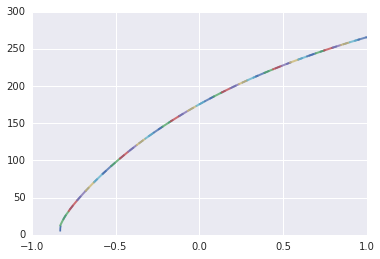

        2
-18.49 x + 102.1 x + 182


In [36]:
G = np.zeros((n_neurons, n_neurons))
U = np.zeros(n_neurons)

# Better algorithm:
# for each neuron, integrate over the whole active region
# for each pair of neurons, integrate over the intersection of the active region

def dint(p, x1, x2):
    """Computes `int_{x1}^{x2} p(x) dx` where `p` is a polynomial."""
    return np.diff(np.polyval(np.polyint(p), [x1, x2]))

def quadratic_taylor(g, dg, ddg):
    """Returns a function that approximates g(ai*ei*x + bi) around x=y."""
    def curve(i, y):
        j = gain[i] * e[i] * y + bias[i]
        f = g(j)
        df = gain[i] * e[i] * dg(j)
        ddf = (gain[i] * e[i])**2 * ddg(j)
        return np.poly1d([
            ddf / 2, df - y * ddf, f - y * df + y**2 * ddf / 2])
    return curve

if neuron_type == nengo.neurons.RectifiedLinear():
    n_segments = 1
    def curve(i, _):
        return np.poly1d([gain[i] * e[i], bias[i]])

elif neuron_type == nengo.neurons.Sigmoid():
    n_segments = min(n_eval_points, 50)
    ref = x.neuron_type.tau_ref
    g = lambda j: 1. / ref / (1 + np.exp(-j))
    dg = lambda j: np.exp(-j) / ref / (1 + np.exp(-j))**2
    ddg = lambda j: 2*np.exp(-2*j) / ref / (1 + np.exp(-j))**3 - dg(j)
    curve = quadratic_taylor(g, dg, ddg)
    
    # Hack to fix intercepts:
    # https://github.com/nengo/nengo/issues/1211
    ON = -np.ones_like(ON)
    OFF = np.ones_like(OFF)
    
elif neuron_type == nengo.neurons.LIFRate():
    n_segments = min(n_eval_points, 50)
    ref = x.neuron_type.tau_ref
    rc = x.neuron_type.tau_rc
    g = lambda j: 1. / (ref + rc * np.log1p(1 / (j - 1)))
    dg = lambda j: g(j)**2 * rc / j / (j - 1)
    ddg = lambda j: (g(j)**3 * rc * (2*rc + ref - 2*j*ref + 
                                     (rc - 2*j*rc)*np.log1p(1 / (j - 1))) /
                     j**2 / (j - 1)**2)
    curve = quadratic_taylor(g, dg, ddg)

else:
    raise ValueError("Unsupported neuron type")

def segments(x1, x2, max_segments, min_width=0.05):
    if x1 >= x2:
        return []
    n_segments = max(min(max_segments, int((x2 - x1) / min_width)), 1)
    r = np.zeros((n_segments, 3))
    r[:, 0] = np.arange(n_segments) * (x2 - x1) / n_segments + x1
    r[:, 2] = np.arange(1, n_segments + 1) * (x2 - x1) / n_segments + x1
    r[:, 1] = (r[:, 0] + r[:, 2]) / 2
    return r
    
i = 1

x_test = np.linspace(-1, 1, 100000)
x_test = x_test[x_test / e[i] > intercepts[i]]
acts = nengo.builder.ensemble.get_activities(sim.data, x, x_test[:, None])

pylab.figure()
pylab.plot(x_test, acts[:, i], linestyle='--', label="Actual")
for j, (x1, xm, x2) in enumerate(segments(ON[i], OFF[i], n_segments)):
    sl = (x_test > x1) & (x_test < x2)
    pylab.plot(x_test[sl], np.polyval(curve(i, xm), x_test[sl]),
               lw=2, alpha=0.8, label="%d" % j)
#pylab.legend()
pylab.show()

print curve(i, xm)
    
############################################################
for i, (li, ui) in enumerate(zip(ON, OFF)):
    for x1, xm, x2 in segments(li, ui, n_segments):
        U[i] += dint(curve(i, xm) * function, x1, x2)
    for j, (lj, uj) in enumerate(zip(ON, OFF)):
        for x1, xm, x2 in segments(max(li, lj), min(ui, uj), n_segments):
            G[i, j] += dint(curve(i, xm) * curve(j, xm), x1, x2)
############################################################

assert np.allclose(G.T, G)

#if np.allclose(solver.reg, 0):
#    d_geo = np.linalg.inv(G).dot(U)

# More complicated solution adapted from:
# https://github.com/nengo/nengo/blob/84db35b5dd673ec715c4b11a0a9afae074f1895f/nengo/utils/least_squares_solvers.py#L32
# in order to make comparisons fair with LstsqL2(reg=reg) where reg > 0.
# Note this is not 'perfect' though because the test set might yield different effective regularization
# than the entire integral. There is probably no way to have a perfect comparison.

# Normalize G and U to be on par with the matrices used by Nengo
# 2 = 1 - (-1) is volume of vector space
G *= len(eval_points) / 2
U *= len(eval_points) / 2

A_nengo = nengo.builder.ensemble.get_activities(sim.data, x, eval_points)
max_rate = np.max(A_nengo)
sigma = solver.reg * max_rate  
m = len(eval_points)
np.fill_diagonal(G, G.diagonal() + m * sigma**2)

factor = scipy.linalg.cho_factor(G, overwrite_a=True)
d_geo = scipy.linalg.cho_solve(factor, U)

In [37]:
# pylab.plot(np.dot(A, d_geo) - Y)

c:\users\aaron\appdata\local\enthought\canopy\user\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


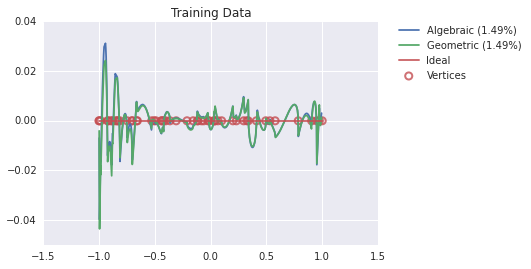

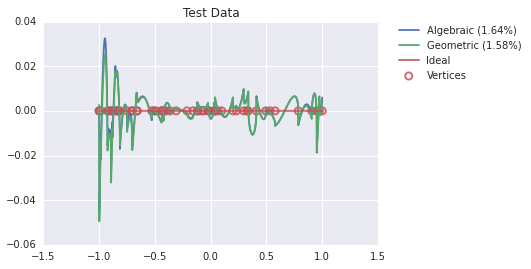

In [38]:
for x_test, title in ((np.sort(eval_points.squeeze()), "Training Data"),
                      (np.linspace(-1, 1, 100000), "Test Data")):
    y = conn.function(x_test)
    activities = nengo.builder.ensemble.get_activities(sim.data, x, x_test[:, None])

    pylab.figure()
    pylab.title(title)
    for d, label in ((d_alg, "Algebraic"),
                     (d_geo, "Geometric")):
        y_hat = np.dot(activities, d).squeeze()
        percent_error = 100 * nengo.utils.numpy.rmse(y_hat, y) / nengo.utils.numpy.rms(y)
        pylab.plot(x_test, y_hat - y, label="%s (%.2f%%)" % (label, percent_error))
    pylab.plot(x_test, np.zeros_like(x_test), lw=2, alpha=0.8, label="Ideal")
    pylab.scatter(X, np.zeros_like(X), facecolors='none', edgecolors=sns.color_palette()[2], alpha=0.8, s=50, lw=2, label="Vertices")
    pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.show()